In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from string import punctuation
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
#import catboost
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [4]:
path = 'train_sent_emo.csv'
train = pd.read_csv(path)

In [5]:
path = 'test_sent_emo.csv'
test = pd.read_csv(path)

In [6]:
path = 'dev_sent_emo_replaced.csv'
dev = pd.read_csv(path)

In [7]:
y_train = []
y_train = pd.DataFrame
y_train = train['Emotion'].copy()

train1 = train.copy()
train.drop(columns=['Sr No.', 'Speaker', 'Sentiment', 'Dialogue_ID', 'Utterance_ID', 'Season', 'Episode', 'StartTime', 'EndTime'], axis=1, inplace=True)
train1 = train.copy()
train.drop(columns=['Emotion'],axis=1, inplace=True)
train

,Utterance
0,also I was the point person on my companys tr...
1,You mustve had your hands full.
2,That I did. That I did.
3,So lets talk a little bit about your duties.
4,My duties? All right.
...,...
9984,You or me?
9985,"I got it. Uh, Joey, women don't have Adam's ap..."
9986,"You guys are messing with me, right?"
9987,Yeah.


In [6]:
# Токенизация
x = word_tokenize(train.loc[1]['Utterance'])

In [7]:
stop = set(stopwords.words('english'))
stop.update(punctuation)

In [8]:
def get_simple_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [9]:
lemmatizer = WordNetLemmatizer()
def clean_review(text):
    clean_text = []
    for w in word_tokenize(text):
        if w.lower() not in stop:
            pos = pos_tag([w])
            new_w = lemmatizer.lemmatize(w, pos=get_simple_pos(pos[0][1]))
            clean_text.append(new_w)
    return clean_text
def join_text(text):
    return " ".join(text)

In [10]:
train.Utterance = train.Utterance.apply(clean_review)
train.Utterance = train.Utterance.apply(join_text)

In [8]:
def normalise_text (text):
    text = text.lower() # lowercase
    text = text.replace(r"\#","") # replaces hashtags
    text = text.replace(r"http\S+","URL")  # remove URL addresses
    text = text.replace(r"@","")
    text = text.replace(r"[^A-Za-z0-9()!?\'\`\"]", " ")
    text = text.replace("\s{2,}", " ")
    return text

In [9]:
train.Utterance = train.Utterance.apply(normalise_text)
test.Utterance = test.Utterance.apply(normalise_text)

In [10]:
train

,Utterance
0,also i was the point person on my companys tr...
1,you mustve had your hands full.
2,that i did. that i did.
3,so lets talk a little bit about your duties.
4,my duties? all right.
...,...
9984,you or me?
9985,"i got it. uh, joey, women don't have adam's ap..."
9986,"you guys are messing with me, right?"
9987,yeah.


In [11]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2),
                        stop_words='english',
                        tokenizer=word_tokenize)
# We transform each utt into a vector
features = tfidf.fit_transform(train.Utterance)
labels = y_train

In [12]:
tfidf_vectorizer=TfidfVectorizer(use_idf=True)
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(train.Utterance)
first_vector_tfidfvectorizer=tfidf_vectorizer_vectors[0]

df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False)

C:\Users\Kate\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,tfidf
kl,0.361051
gr,0.361051
transition,0.361051
company,0.319368
system,0.313520
...,...
flew,0.000000
flesh,0.000000
flennin,0.000000
flea,0.000000


In [13]:
labels = train1['Emotion']

In [14]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0, max_iter=1000),
    CatBoostClassifier(),
    LGBMClassifier()
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, tfidf_vectorizer_vectors, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

Learning rate set to 0.087974
0:	learn: 1.8620544	total: 247ms	remaining: 4m 6s
1:	learn: 1.8007285	total: 333ms	remaining: 2m 46s
2:	learn: 1.7501627	total: 433ms	remaining: 2m 23s
3:	learn: 1.7101168	total: 529ms	remaining: 2m 11s
4:	learn: 1.6790183	total: 621ms	remaining: 2m 3s
5:	learn: 1.6528888	total: 712ms	remaining: 1m 57s
6:	learn: 1.6309686	total: 814ms	remaining: 1m 55s
7:	learn: 1.6119680	total: 912ms	remaining: 1m 53s
8:	learn: 1.5973684	total: 1000ms	remaining: 1m 50s
9:	learn: 1.5830300	total: 1.09s	remaining: 1m 48s
10:	learn: 1.5716930	total: 1.19s	remaining: 1m 46s
11:	learn: 1.5554969	total: 1.27s	remaining: 1m 44s
12:	learn: 1.5444731	total: 1.36s	remaining: 1m 43s
13:	learn: 1.5367027	total: 1.46s	remaining: 1m 42s
14:	learn: 1.5273697	total: 1.56s	remaining: 1m 42s
15:	learn: 1.5183614	total: 1.65s	remaining: 1m 41s
16:	learn: 1.5105081	total: 1.75s	remaining: 1m 40s
17:	learn: 1.5043843	total: 1.84s	remaining: 1m 40s
18:	learn: 1.4984018	total: 1.93s	remaining: 

In [23]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1,
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
CatBoostClassifier,0.516969,0.006153
LGBMClassifier,0.489739,0.004606
LinearSVC,0.487937,0.010121
LogisticRegression,0.515067,0.005791
MultinomialNB,0.493844,0.003015
RandomForestClassifier,0.471519,0.000193


In [39]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1,
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
CatBoostClassifier,0.525278,0.004728
LGBMClassifier,0.505956,0.006352
LinearSVC,0.502453,0.010154
LogisticRegression,0.523475,0.006638
MultinomialNB,0.491540,0.004344
RandomForestClassifier,0.471519,0.000106


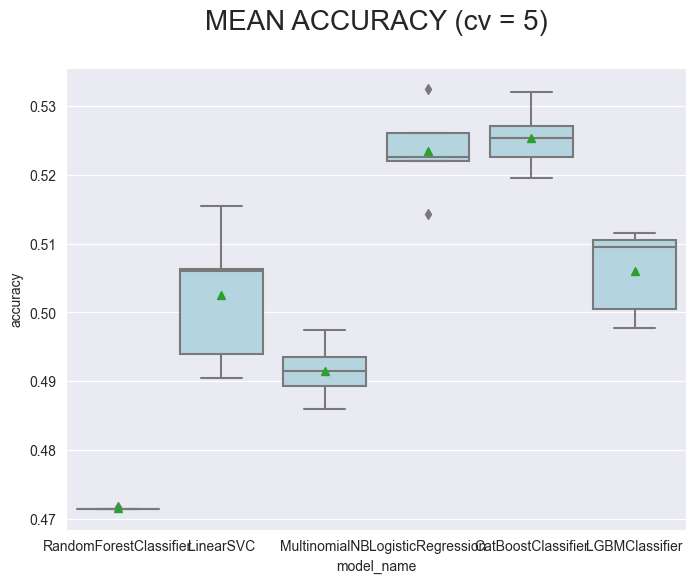

In [40]:
plt.figure(figsize=(8,6))
sns.boxplot(x='model_name', y='accuracy',
            data=cv_df,
            color='lightblue',
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=20);

In [105]:
model = LogisticRegression(random_state=0, max_iter=1000)
model.fit(tfidf_vectorizer_vectors, y_train)

LogisticRegression(max_iter=1000, random_state=0)

In [106]:
test.Utterance = test.Utterance.apply(clean_review)
test.Utterance = test.Utterance.apply(join_text)
test.drop(columns=['Sr No.', 'Speaker', 'Sentiment', 'Dialogue_ID', 'Utterance_ID', 'Season', 'Episode', 'StartTime', 'EndTime', 'Emotion'], axis=1, inplace=True)
test

,Utterance
0,youre coffee mug number bottom
1,Oh Thats Monica keep track way one miss like ...
2,Y'know
3,Come Lydia
4,Push
...,...
2605,Yeah mean come Ross one even notice mean ’ pro...
2606,’ listen
2607,course ’ listen Everybody listens
2608,Monica really think try phase thing


In [15]:
features_test = tfidf_vectorizer.transform(test.Utterance)
y_test = test.Emotion.copy()
test

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,why do all youre coffee mugs have numbers on ...,Mark,surprise,positive,0,0,3,19,"00:14:38,127","00:14:40,378"
1,2,oh. thats so monica can keep track. that way ...,Rachel,anger,negative,0,1,3,19,"00:14:40,629","00:14:47,385"
2,3,y'know what?,Rachel,neutral,neutral,0,2,3,19,"00:14:56,353","00:14:57,520"
3,19,"come on, lydia, you can do it.",Joey,neutral,neutral,1,0,1,23,"0:10:44,769","0:10:46,146"
4,20,push!,Joey,joy,positive,1,1,1,23,"0:10:46,146","0:10:46,833"
...,...,...,...,...,...,...,...,...,...,...,...
2605,2760,"yeah, i mean, come on ross, no one will even n...",Rachel,neutral,neutral,279,11,6,4,"00:14:35,457","00:14:40,211"
2606,2761,they’re not listening too me?,Ross,surprise,negative,279,12,6,4,"00:14:42,256","00:14:43,840"
2607,2762,of course they’re listening to you! everybody ...,Rachel,neutral,neutral,279,13,6,4,"00:14:44,008","00:14:48,511"
2608,2763,monica you really think i should try this phas...,Ross,neutral,neutral,279,14,6,4,"00:14:48,138","00:14:52,390"


In [ ]:
y_pred = model.predict(features_test)

In [111]:
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred,
                                    target_names= train1['Emotion'].unique()))

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

     neutral       0.32      0.07      0.11       345
    surprise       0.50      0.03      0.06        68
        fear       0.00      0.00      0.00        50
     sadness       0.47      0.22      0.30       402
         joy       0.53      0.91      0.67      1256
     disgust       0.49      0.09      0.15       208
       anger       0.53      0.30      0.38       281

    accuracy                           0.52      2610
   macro avg       0.41      0.23      0.24      2610
weighted avg       0.48      0.52      0.44      2610



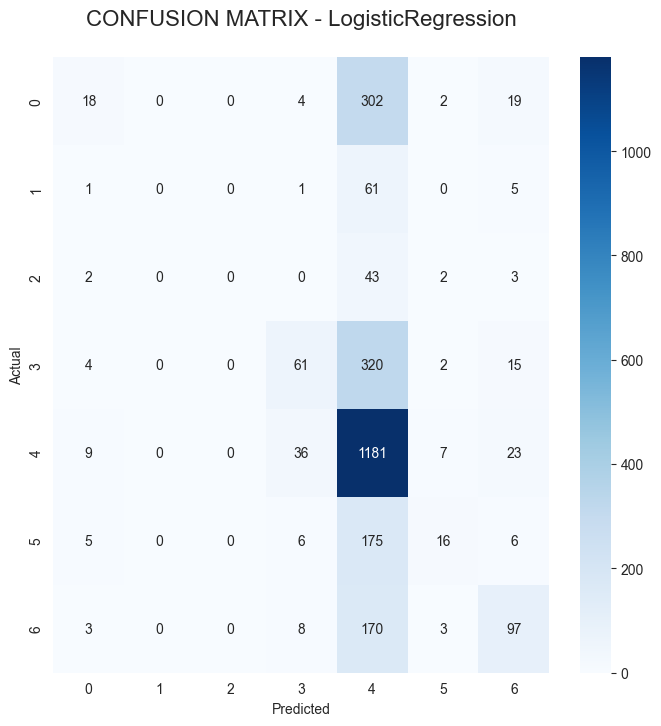

In [45]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')#,
            # xticklabels=pd.DataFrame(train1['Emotion'].unique()).values,
            # yticklabels=pd.DataFrame(train1['Emotion'].unique()).values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LogisticRegression\n", size=16);

In [42]:
cb = CatBoostClassifier()
cb.fit(tfidf_vectorizer_vectors, y_train)

Learning rate set to 0.088981
0:	learn: 1.8590103	total: 111ms	remaining: 1m 50s
1:	learn: 1.7941868	total: 214ms	remaining: 1m 47s
2:	learn: 1.7437333	total: 314ms	remaining: 1m 44s
3:	learn: 1.7051699	total: 409ms	remaining: 1m 41s
4:	learn: 1.6749220	total: 507ms	remaining: 1m 40s
5:	learn: 1.6482437	total: 606ms	remaining: 1m 40s
6:	learn: 1.6222426	total: 704ms	remaining: 1m 39s
7:	learn: 1.6018356	total: 809ms	remaining: 1m 40s
8:	learn: 1.5856174	total: 908ms	remaining: 1m 39s
9:	learn: 1.5703930	total: 1.01s	remaining: 1m 39s
10:	learn: 1.5579552	total: 1.12s	remaining: 1m 40s
11:	learn: 1.5451520	total: 1.24s	remaining: 1m 42s
12:	learn: 1.5331629	total: 1.35s	remaining: 1m 42s
13:	learn: 1.5245754	total: 1.46s	remaining: 1m 42s
14:	learn: 1.5156037	total: 1.58s	remaining: 1m 43s
15:	learn: 1.5090621	total: 1.69s	remaining: 1m 43s
16:	learn: 1.5017086	total: 1.8s	remaining: 1m 43s
17:	learn: 1.4970076	total: 1.91s	remaining: 1m 43s
18:	learn: 1.4933175	total: 2.02s	remaining: 

In [43]:
y_pred = cb.predict(features_test)

In [44]:
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred,
                                    target_names= train1['Emotion'].unique()))

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

     neutral       0.43      0.05      0.09       345
    surprise       0.00      0.00      0.00        68
        fear       0.00      0.00      0.00        50
     sadness       0.53      0.15      0.24       402
         joy       0.52      0.94      0.67      1256
     disgust       0.50      0.08      0.13       208
       anger       0.58      0.35      0.43       281

    accuracy                           0.53      2610
   macro avg       0.37      0.22      0.22      2610
weighted avg       0.49      0.53      0.43      2610



C:\Users\Kate\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Kate\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Kate\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [46]:
clf = LogisticRegression(penalty= 'elasticnet', solver= 'saga', l1_ratio=0.5, random_state=1).fit(tfidf_vectorizer_vectors, y_train)
y_pred= clf.predict(features_test)

In [49]:
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred))

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

       anger       0.30      0.06      0.10       345
     disgust       1.00      0.04      0.08        68
        fear       0.20      0.02      0.04        50
         joy       0.50      0.21      0.29       402
     neutral       0.54      0.91      0.68      1256
     sadness       0.50      0.06      0.11       208
    surprise       0.53      0.39      0.45       281

    accuracy                           0.53      2610
   macro avg       0.51      0.24      0.25      2610
weighted avg       0.50      0.53      0.44      2610



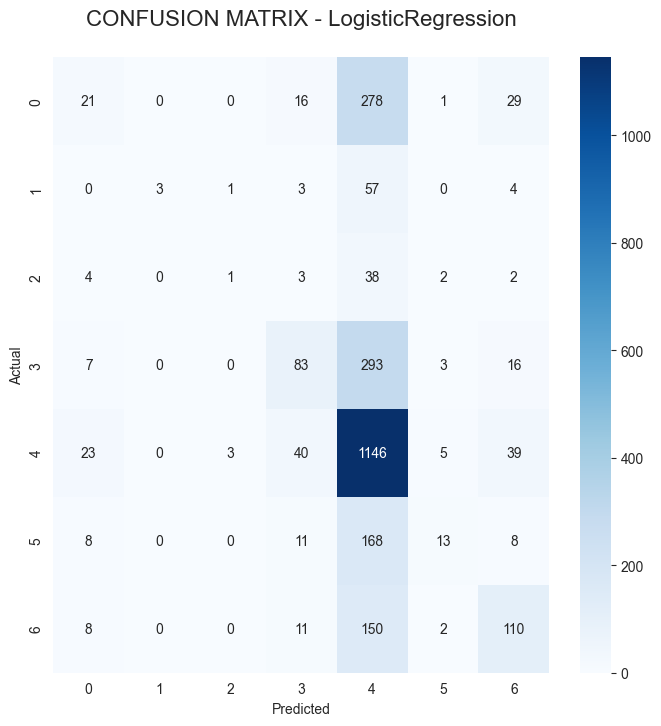

In [50]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LogisticRegression\n", size=16);

In [37]:
clf = LogisticRegression(penalty= 'elasticnet', solver= 'saga', l1_ratio=1, random_state=42).fit(tfidf_vectorizer_vectors, y_train)
y_pred= clf.predict(features_test)

C:\Users\Kate\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [38]:
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred))

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

       anger       0.33      0.07      0.12       345
     disgust       0.80      0.06      0.11        68
        fear       0.17      0.02      0.04        50
         joy       0.48      0.21      0.30       402
     neutral       0.54      0.90      0.67      1256
     sadness       0.52      0.07      0.13       208
    surprise       0.53      0.41      0.46       281

    accuracy                           0.53      2610
   macro avg       0.48      0.25      0.26      2610
weighted avg       0.50      0.53      0.45      2610



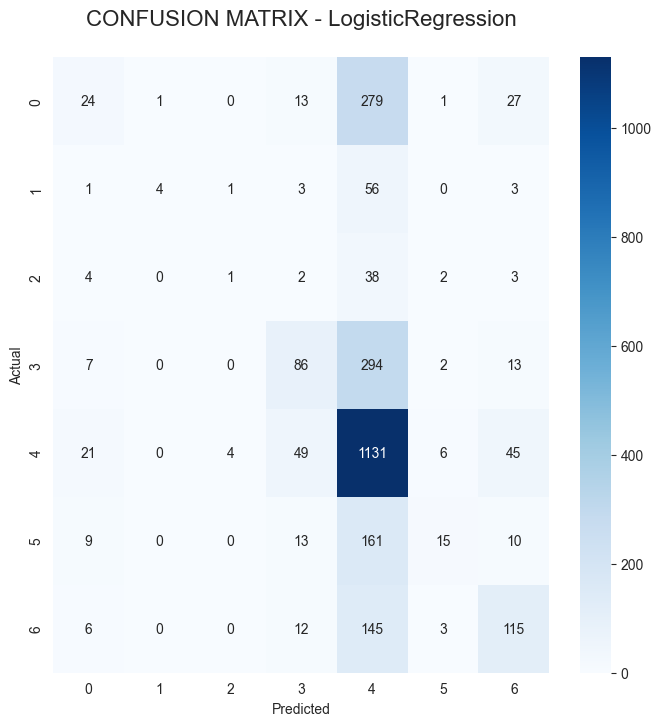

In [39]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LogisticRegression\n", size=16);